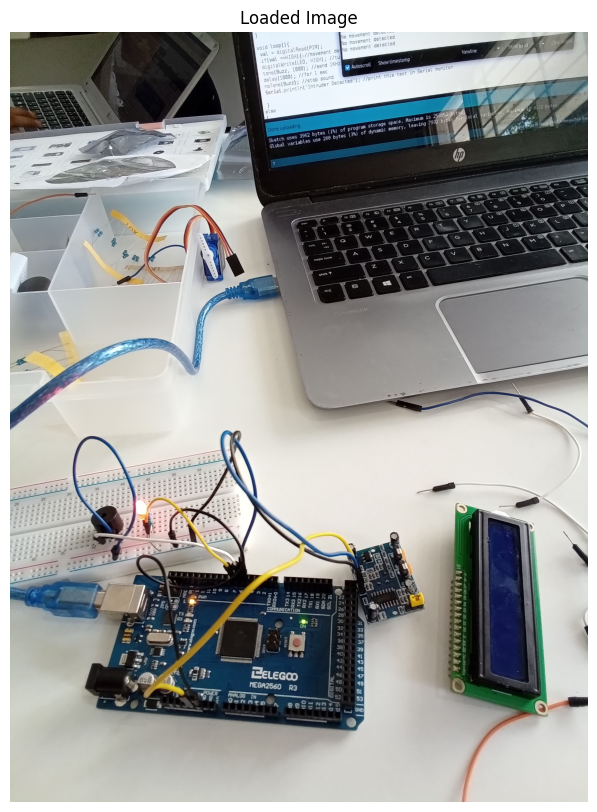

In [31]:
import cv2
import matplotlib.pyplot as plt

def show_image(img, title='Image', cmap_type='gray'):
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load an image
image_path = '/content/image1.jpg'  # Update this path to your image
image = cv2.imread(image_path)

# Convert BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
show_image(image_rgb, title='Loaded Image')


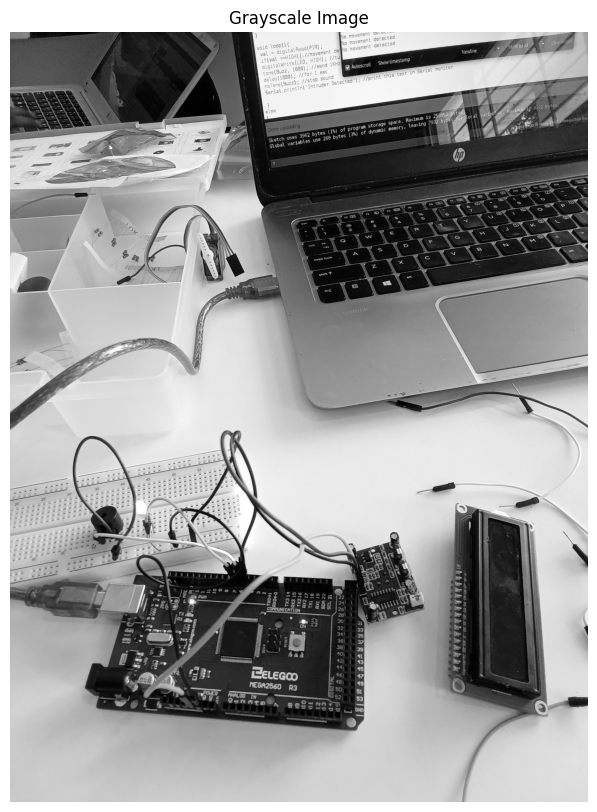

In [32]:
# Convert image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
show_image(gray_image, title='Grayscale Image', cmap_type='gray')


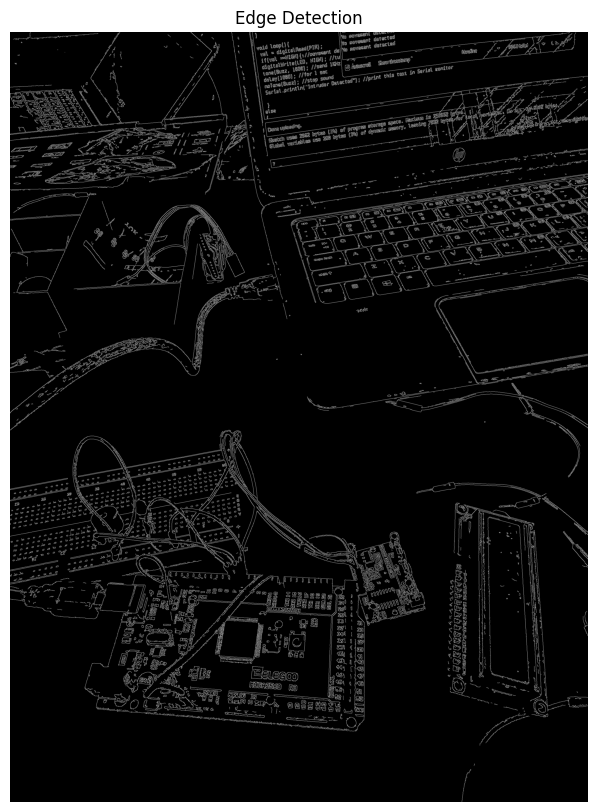

In [33]:
# Perform edge detection
edges = cv2.Canny(gray_image, 100, 200)
show_image(edges, title='Edge Detection', cmap_type='gray')


In [34]:
! wget https://pjreddie.com/media/files/yolov3.weights -O yolov3.weights
! wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg -O yolov3.cfg
! wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names -O coco.names


--2024-06-14 11:46:18--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  13.2MB/s    in 18s     

2024-06-14 11:46:37 (13.4 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2024-06-14 11:46:37--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2

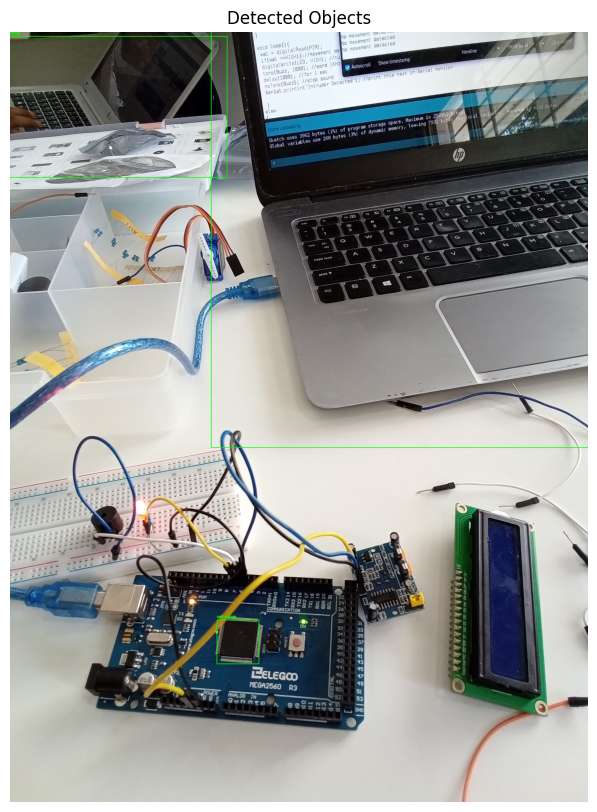

In [35]:
import numpy as np

# Load YOLO model and classes
net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')
with open('coco.names', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

layer_names = net.getLayerNames()
unconnected_out_layers = net.getUnconnectedOutLayers()
if isinstance(unconnected_out_layers[0], list) or isinstance(unconnected_out_layers[0], np.ndarray):
    output_layers = [layer_names[i[0] - 1] for i in unconnected_out_layers]
else:
    output_layers = [layer_names[i - 1] for i in unconnected_out_layers]

# Object detection function
def detect_objects(img):
    height, width, channels = img.shape
    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = (0, 255, 0)
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return img

# Load an example image
image_path = '/content/image1.jpg'  # Update this path to your image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform object detection
detected_image = detect_objects(image)

# Display detected objects
show_image(detected_image, title='Detected Objects')


1/1 [==============================] - 1s 847ms/step
1: laptop (0.31)
2: oscilloscope (0.19)
3: modem (0.12)


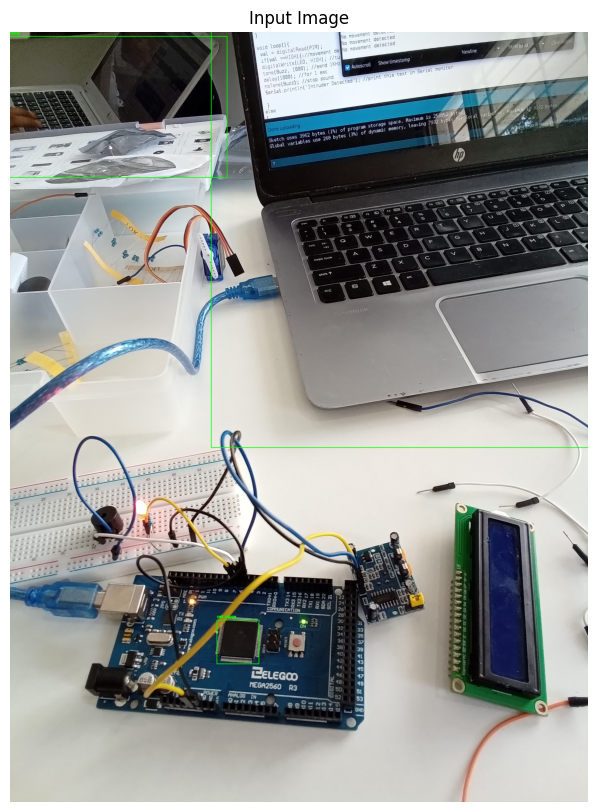

In [36]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

# Load pre-trained ResNet50 model
model = ResNet50(weights='imagenet')

# Preprocess the image
img_resized = cv2.resize(image, (224, 224))
img_array = np.expand_dims(img_resized, axis=0)
img_preprocessed = preprocess_input(img_array)

# Predict the class
predictions = model.predict(img_preprocessed)
decoded_predictions = decode_predictions(predictions, top=3)[0]

# Print predictions
for i, (imagenet_id, label, score) in enumerate(decoded_predictions):
    print(f"{i + 1}: {label} ({score:.2f})")

# Optionally, display the image
show_image(image, title='Input Image')
